### Generalized Method of Moments Intuition Python Tutorial 

#### Please note that we won't really go into any optimization details, mechanistic models, or any of those details as those are all built into BioNetGMMFit. But, what we want to do is provide an example with some figures that show intuitively why GMM is useful and how it affects the feature space that is applied to the cost function. In particular, let "m" be the moment difference vectors between observed and predicted moments, let us find what the GMM weight matrix "W" is for our cost function "m'*w*m" along with how it changes each of the moments. 

In [255]:
import numpy as np
import matplotlib.pyplot as plt

#### Generate The Observed and Predicted Datasets, Note that the predicted dataset generated from the model from the optimization routine will often have different sample moments, so let us just assume different moment parameters for the sake of our presentation. We generate some data sampled from multivariate lognormal distributions as that is what is used in the paper.

In [256]:
def generate_lognormal_samples(mean, covariance, N):
    """
    Generate an N by m matrix by sampling from a lognormal distribution.

    Arguments:
    - mean: A 1D array-like object representing the mean vector.
    - covariance: A 2D array-like object representing the covariance matrix.
    - N: Number of samples (rows) in the matrix.

    Returns:
    - A numpy array of shape (N, m) representing the generated matrix.
    """

    # Generate correlated normal samples
    lognormal_samples = np.random.multivariate_normal(np.log(mean), np.log(covariance), N)

    # Apply lognormal transformation to the correlated samples
    lognormal_samples = np.exp(lognormal_samples)

    return lognormal_samples

#### Note that the data we generated are of two types, an observed dataset that you would observe in practice, and a predicted dataset that you would produce from your model. There are two proteins in this dataset.

In [257]:
N = 500
n_proteins = 2
covariance_observed = np.array([[1,2],[3,4]])

covariance_predicted = 1.20 * covariance_observed
observedSamples = generate_lognormal_samples(mean=5.5*np.ones(n_proteins), covariance=covariance_observed, N=N)
predictedSamples = generate_lognormal_samples(mean=6.2*np.ones(n_proteins), covariance=covariance_predicted, N=N)
print(observedSamples.shape)
print(predictedSamples.shape)
print(observedSamples.mean(axis=0))
print(predictedSamples.mean(axis=0))


(500, 2)
(500, 2)
[ 8.9845958  11.27638617]
[10.96058819 13.01836608]


C:\Users\jhnwu\AppData\Local\Temp\ipykernel_6592\1477180660.py:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  lognormal_samples = np.random.multivariate_normal(np.log(mean), np.log(covariance), N)


#### Data Points on a 2D Scatter Plot, x-axis is protein 1, y-axis is protein 2

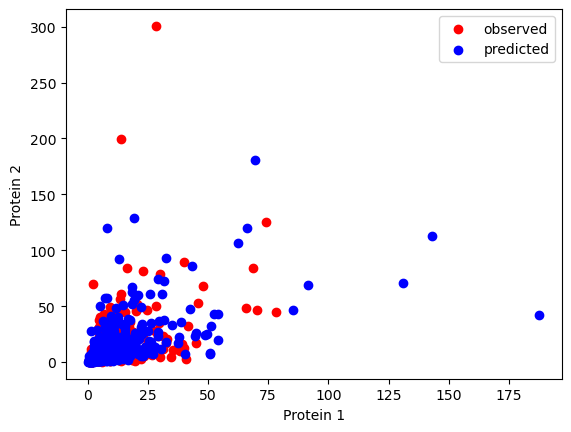

In [258]:
plt.figure()
plt.scatter(observedSamples[:,0],observedSamples[:,1], label="observed", c="r")
plt.scatter(predictedSamples[:,0], predictedSamples[:,1], label="predicted", c="b")
plt.xlabel("Protein 1")
plt.ylabel("Protein 2")
plt.legend()

#### Their Corresponding Observed and Predicted Moments on a 2D Scatter Plot. In this case, we only consider means and variances as those are easier to plot, we will also investigate the covariances later. But please just observe how much the moments vary from one another (where variances are much larger than the means).

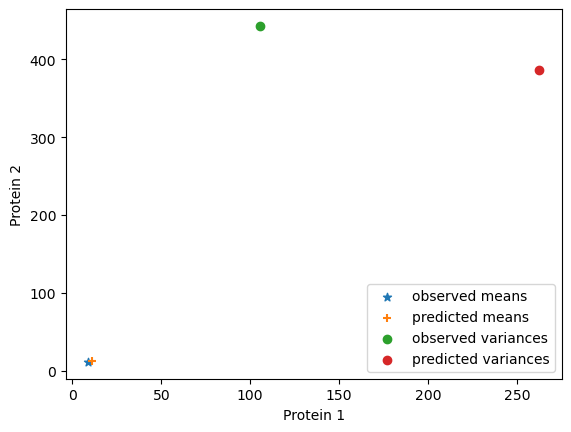

In [259]:
obs_means = np.mean(observedSamples,axis=0)
obs_var = np.var(observedSamples, axis=0)
pred_means = np.mean(predictedSamples, axis=0)
pred_var = np.var(predictedSamples, axis=0)
plt.figure()
plt.scatter(obs_means[0], obs_means[1], label="observed means",marker="*")
plt.scatter(pred_means[0], pred_means[1], label="predicted means", marker="+")
plt.scatter(obs_var[0], obs_var[1], label="observed variances")
plt.scatter(pred_var[0], pred_var[1], label="predicted variances")
plt.xlabel("Protein 1")
plt.ylabel("Protein 2")
plt.legend()

#### Quick look at the magnitude of the covariances.

In [260]:
obs_cov = np.cov(observedSamples,rowvar=False)[0,0]
pred_cov = np.cov(predictedSamples,rowvar=False)[0,0]
print("covariance of the observed values", obs_cov)
print("covariance of the predicted values", pred_cov)

covariance of the observed values 105.56881412852363
covariance of the predicted values 263.17276748147106


#### Now, when taking their square differences for what one might use in their cost function (i.e square error with an identity weight matrix, etc.), observe this issue of different orders of magnitude still persists where the variance differences is much larger than the mean! 

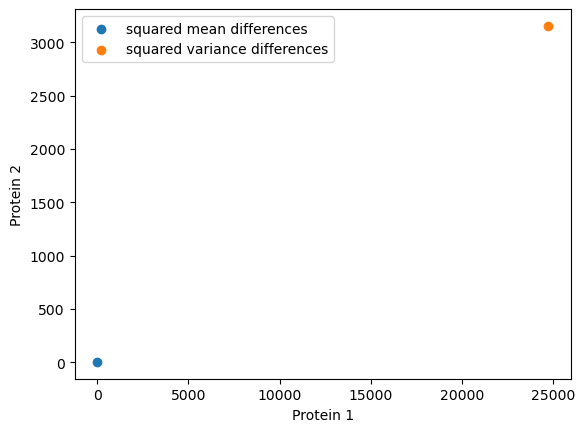

In [261]:
plt.figure()
plt.scatter(np.square(obs_means[0] - pred_means[0]), np.square(obs_means[1] - pred_means[1]), label="squared mean differences")
plt.scatter(np.square(obs_var[0] - pred_var[0]), np.square(obs_var[1] - pred_var[1]), label="squared variance differences")
plt.xlabel("Protein 1")
plt.ylabel("Protein 2")
plt.legend()

#### Now, let's do some GMM (i.e compute a GMM weight matrix, please understand this is just one of the ways of doing so), and consider covariance moments in this differencing too! In particular, it computes a weight matrix from the observed sample moments as described in the Wolf and Luck GMM for biochemical signaling paper. Let's take a look. Please read the comments if you have any questions regarding what is happening in the GMM weight function.

In [262]:
def gmm_weights(observedSamples):
    # analytical solution of how many moments we're considering
    nMoments = observedSamples.shape[1] * (observedSamples.shape[1] + 3) / 2
    nCross = nMoments - 2*observedSamples.shape[1]
    
    # Let's compute a bunch of sample differences, all associated with the expected differences of each type of moment.
    first_differences = observedSamples - observedSamples.mean()
    second_differences = np.multiply(observedSamples, observedSamples) - (observedSamples.mean() * observedSamples.mean())
    cross_differences = np.zeros((observedSamples.shape[0], int(nCross)))
    cross = 0
    for i in range(observedSamples.shape[1]):
        for j in range(i+1,observedSamples.shape[1]):
            cross_differences[:,cross] = np.multiply(observedSamples[:,i], observedSamples[:,j]) - np.multiply(observedSamples[:,i].mean(), observedSamples[:,j].mean())
    
    # concatenate all differences into a singular_matrix
    all_diffs = np.concatenate([first_differences, second_differences, cross_differences],axis=1)        
    
    # Now let's compute the covariances of each of these different types of sample differences that are directly related to the moments we care about.
    cov = np.cov(all_diffs,rowvar=False)
    
    # This allows us to create the mahalonobis distance weight matrix of the variance of moments aka the GMM weight matrix
    return np.linalg.inv(cov)
    

#### Plot the new moment differences associated with the means and variances.

In [263]:
W = gmm_weights(observedSamples=observedSamples)
print(W.shape)

(5, 5)


In [264]:
obs_m = np.concatenate((obs_means, (obs_var), np.array([obs_cov])))
pred_m = np.concatenate((pred_means, (pred_var), np.array([pred_cov])))
m = obs_m - pred_m

#### Now taking these moment differences into account, observe that both mean and variance differences are within the same scaling! This is very useful in making sure the cost functio isn't overshadowed by one of the moment calculations. Now, see that the order of magnitude of the mean differences are now in line with the variance differences when weighed by the GMM weight matrix.

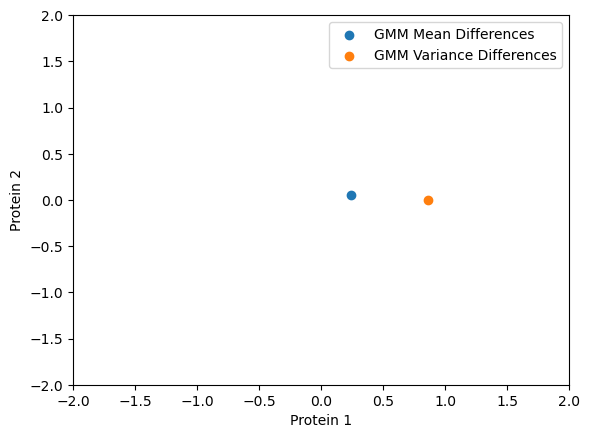

In [265]:
gmm_diff_vec = m * W.diagonal() * m
plt.figure()
plt.scatter(gmm_diff_vec[0], gmm_diff_vec[1], label="GMM Mean Differences")
plt.scatter(gmm_diff_vec[2], gmm_diff_vec[3], label="GMM Variance Differences")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("Protein 1")
plt.ylabel("Protein 2")
plt.legend()

#### Looking at the difference in cost evaluations. Observe the difference.

In [266]:
gmm_cost = m @ W @ m
square_cost = m @  np.identity(5) @ m

print("GMM Cost:", gmm_cost)
print("Square (Identity) Cost:", square_cost)

GMM Cost: 0.10490783945954789
Square (Identity) Cost: 52738.88159956878
